In [1]:
from autograd import grad, jacobian
import autograd.numpy as np
from matplotlib import pyplot as plt

In [2]:
class ILqr:
    
    def __init__(self, dynamics, running_cost, final_cost, state_dim, horizon=50):
        
        self.f = dynamics
        self.horizon = horizon
        
        self.f_x = jacobian(self.f,0)
        self.f_u = jacobian(self.f,1)
        
        self.f_xx = jacobian(self.f_x, 0)
        self.f_uu = jacobian(self.f_u, 1)
        self.f_ux = jacobian(self.f_u, 0)
        
        self.lf = final_cost
        self.lf_x = grad(self.lf,0)
        self.lf_xx = jacobian(self.lf_x,0)
        
        
        self.v = [0.0 for _ in range(horizon+1)]
        self.v_x = [np.zeros(state_dim) for _ in range(horizon+1)]
        self.v_xx = [np.zeros((state_dim,state_dim)) for _ in range(horizon+1)]
        
        self.l = running_cost
        self.l_x = grad(self.l,0)
        self.l_u = grad(self.l,1)
        
        self.l_xx = jacobian(self.l_x,0)
        self.l_uu = jacobian(self.l_u,1)
        self.l_ux = jacobian(self.l_u,0)
        
    def backward(self, x_seq, u_seq):
        
        self.v[-1] = self.lf(x_seq[-1],u_seq[-1])
        self.v_x[-1] = self.lf_x(x_seq[-1],u_seq[-1])
        self.v_xx[-1] = self.lf_xx(x_seq[-1],u_seq[-1])
        
        k_seq = []
        kk_seq = []
        
        for t in range(self.horizon-1,-1,-1):
            
            x = x_seq[t]
            u = u_seq[t]
            
            # Evaluate expansion coeeficients
            f_x_t = self.f_x(x,u)
            f_u_t = self.f_u(x,u)
            
            f_xx_t = self.f_xx(x,u)
            f_uu_t = self.f_uu(x,u)
            f_ux_t = self.f_ux(x,u)
            
            l_x_t = self.l_x(x,u)
            l_u_t = self.l_u(x,u)
            
            l_xx_t = self.l_xx(x,u)
            l_uu_t = self.l_uu(x,u)
            l_ux_t = self.l_ux(x,u)
            
            v_x_t = self.v_x[t+1]
            v_xx_t = self.v_xx[t+1]
            
            q_x = l_x_t + np.matmul(f_x_t.T,v_x_t)
            q_u = l_u_t + np.matmul(f_u_t.T,v_x_t)
            
            q_xx = l_xx_t + np.matmul(np.matmul(f_x_t.T,v_xx_t),f_x_t) + (v_x_t.reshape(-1,1,1)*f_xx_t).sum(axis=0)
            
            q_uu = l_uu_t + np.matmul(np.matmul(f_u_t.T,v_xx_t),f_u_t) + (v_x_t.reshape(-1,1,1)*f_uu_t).sum(axis=0)
            
            q_ux = l_ux_t + ((f_u_t.T).dot(v_xx_t)).dot(f_x_t) + (v_x_t.reshape(-1,1,1)*f_ux_t).sum(axis=0)
        
            q_uu_inv = np.linalg.inv(q_uu+1e-9*np.eye(q_uu.shape[0]))
            
            k = -q_uu_inv.dot(q_u) # open loop gain
            kk = -q_uu_inv.dot(q_ux) # feedback gain
            
            
            self.v[t] += 0.5*(k.T.dot(q_uu)).dot(k) + k.T.dot(q_u)#q_u.dot(k)
            self.v_x[t] = q_x + (kk.T.dot(q_uu)).dot(k) + kk.T.dot(q_u) + q_ux.T.dot(k)#q_u.dot(kk)
            self.v_xx[t] = q_xx + (kk.T.dot(q_uu)).dot(kk) + kk.T.dot(q_ux) + q_ux.T.dot(kk)#q_ux.T.dot(kk)
            
            k_seq.append(k)
            kk_seq.append(kk)
        
        k_seq.reverse()
        kk_seq.reverse()
        
        return k_seq,kk_seq
    
    def forward(self, x_seq, u_seq, k_seq, kk_seq,alpha):
        
        x_seq_hat = np.array(x_seq)
        u_seq_hat = np.array(u_seq)
        
        for t in range(len(u_seq)):
            control = alpha**t*k_seq[t] + np.matmul(kk_seq[t], (x_seq_hat[t] - x_seq[t]))
            u_seq_hat[t] = np.clip(u_seq[t] + control,-0.5,0.5)
            x_seq_hat[t+1] = self.f(x_seq_hat[t], u_seq_hat[t])
            
        return x_seq_hat, u_seq_hat

In [3]:
def update(x,u):
    
    dt = 0.05
    x0 = x[0] + u[0]*np.cos(x[2])*dt
    x1 = x[1] + u[0]*np.sin(x[2])*dt
    x2 = x[2] + u[1]*dt
    
    return np.array((x0,x1,x2))

In [4]:
ilqr = ILqr(lambda x, u: update(x, u), lambda x, u: 0.025*np.sum(np.square(u)), lambda x, u: 1*np.square(x[0]-2) + 1*np.square(x[1]-1.5), 3, horizon=200)

In [5]:
u_seq = [0.3*np.random.randn((2)) for _ in range(ilqr.horizon)]
x_seq = [np.zeros((3))]
for t in range(ilqr.horizon):
    x_seq.append(update(x_seq[-1], u_seq[t]))
x_seq = np.array(x_seq)
u_seq = np.array(u_seq)

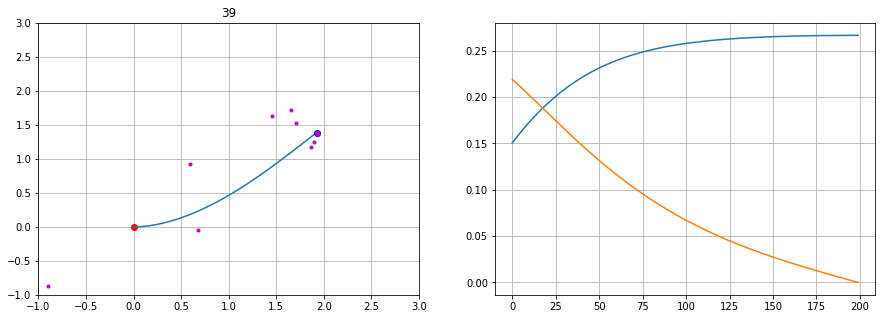

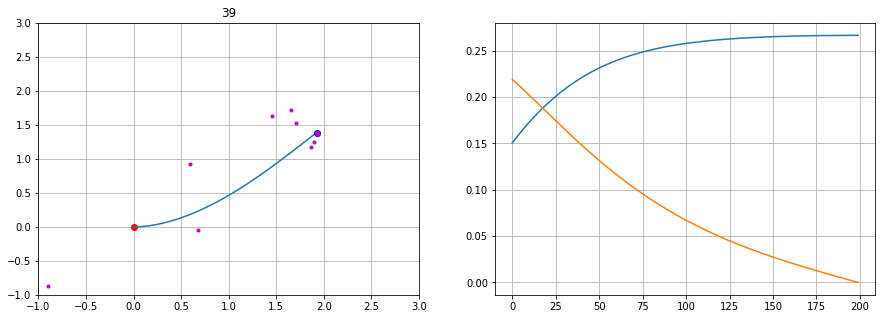

In [6]:
from IPython import display
reps = 40

goals = []
plt.figure(figsize=(15,5))
for j in range(reps):
    k_seq, kk_seq = ilqr.backward(x_seq, u_seq)
    x_seq, u_seq = ilqr.forward(x_seq, u_seq, k_seq, kk_seq,alpha=1)
    
    goals.append(x_seq[-1,:])
    #if (j % 10):
    plt.cla()
    plt.subplot(1,2,1)
    plt.cla()
    plt.plot(x_seq[0,0],x_seq[0,1],'ro')
    plt.plot(x_seq[:,0],x_seq[:,1])
    plt.plot(x_seq[-1,0],x_seq[-1,1],'bo')
    plt.plot(np.array(goals)[:,0],np.array(goals)[:,1],'m.')
    plt.xlim(-1,3)
    plt.ylim(-1,3)
    plt.grid()
    plt.title(j)

    plt.subplot(1,2,2)
    plt.cla()
    plt.plot(u_seq)
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())